# Best SIP Date with Highest Returns

This is a simple analysis to find out which SIP date had yielded highest returns. The standard SIP dates considered are 1st, 5th, 10th, 15th, 20th, 25th of calendar month.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from babel.numbers import format_currency
from datetime import datetime

## Load Data
Load the data into a pandas data frame

In [2]:
import requests
def loadDataFromWeb():
    #make web request
    from datetime import datetime
    url = "http://portal.amfiindia.com/DownloadNAVHistoryReport_Po.aspx"

    querystring = {"mf":"64","tp":"1","frmdt":"01-Jan-1979","todt":datetime.today().strftime('%d-%b-%Y')}

    headers = {
        'cache-control': "no-cache"
        }

    response = requests.request("GET", url, headers=headers, params=querystring)
    
    #build dataframe
    cols = []
    lst = []
    for cnt, line in enumerate(response.text.splitlines()):
        line = line.strip()
        props = line.split(';')
        if len(props) > 1 :
            #process
            if cnt == 0:
                cols =  props
            elif cnt == 1:
                print(props)
            else:
                lst.append(props)
    response = None
    df = pd.DataFrame(lst, columns = cols)
    return df

In [3]:
def loadDataFromFile(filepath):
    cols = []
    lst = []
    with open(filepath) as fp:
        for cnt, line in enumerate(fp):
            line = line.strip()
            props = line.split(';')
            if len(props) > 1 :
                #process
                if cnt == 0:
                    cols =  props
                elif cnt == 1:
                    print(props)
                else:
                    lst.append(props)

    df = pd.DataFrame(lst, columns = cols)
    return df

## Data wrangling
### Handling Missing NAV
As the NAV is not available on weekends and holidays, the back fill approach is follwed. This means, the NAVs for weekends are back filled with that of succeeding Monday's NAVs. Other missing days' Nav such as holidays are filled with NAV of the next available day.

By default all the data loaded into a pandas dataframe will be in string format. To smoothen the data access and analysis easier, cast the 'Date' column to DateTime and 'Net Asset Value' column to float.

Also, control the range of NAVs to be processed by a numeric variable 'yearsToConsider'. This is to calculate the seperate of highest SIP returns yielding date for tenures of 1 year, 3 years, 5 years and so on. For example, set yearsToConsider value to 3 to know the best SIP date that had yielded the highest returns if the SIP had been initiated back 3 years from today (or from latest available NAV date in the dataset).

In [4]:
def preprocessing(df, schemeCode, yearsToConsider):
    df['Date'] =  pd.to_datetime(df['Date'], format='%d-%b-%Y')
    df['Net Asset Value'] = pd.to_numeric(df['Net Asset Value'], errors='coerce')
    df['Repurchase Price'] = pd.to_numeric(df['Repurchase Price'], errors='coerce')
    df['Sale Price'] = pd.to_numeric(df['Sale Price'], errors='coerce')
    df1 = df[df['Scheme Code']==schemeCode][['Net Asset Value','Date']]
    #fill navs on weekends with the monday's nav. Other missing days' Nav such as holidays will be filled with the nav for the next available date
    df1 = df1.set_index('Date').asfreq('d', method='bfill')
    df1 = df1[df1.index.max()-np.timedelta64(yearsToConsider,'Y'):df1.index.max()]
    return df1

In [5]:
import scipy.optimize

def xnpv(rate, values, dates):
    '''Equivalent of Excel's XNPV function.

    >>> from datetime import date
    >>> dates = [date(2010, 12, 29), date(2012, 1, 25), date(2012, 3, 8)]
    >>> values = [-10000, 20, 10100]
    >>> xnpv(0.1, values, dates)
    -966.4345...
    '''
    if rate <= -1.0:
        return float('inf')
    d0 = dates[0]    # or min(dates)
    return sum([ vi / (1.0 + rate)**((di - d0).days / 365.0) for vi, di in zip(values, dates)])

def xirr(values, dates):
    '''Equivalent of Excel's XIRR function.

    >>> from datetime import date
    >>> dates = [date(2010, 12, 29), date(2012, 1, 25), date(2012, 3, 8)]
    >>> values = [-10000, 20, 10100]
    >>> xirr(values, dates)
    0.0100612...
    '''
    try:
        return scipy.optimize.newton(lambda r: xnpv(r, values, dates), 0.0)
    except RuntimeError:    # Failed to converge?
        return scipy.optimize.brentq(lambda r: xnpv(r, values, dates), -1.0, 1e10)

In [6]:
#Compounded Annual Growth Rate
def CAGR(L,F,Terms):
    N = Terms/12
    if N == 0:
        return 0
    return 100*((L/F)**(1/N)-1)

In [7]:
#Absolute Return
def AbsReturn(L,F):
    absRet = round(100*(L-F)/F, 3)
    return absRet

In [8]:
#Simple Annualised Return
def SAR(L,F,Terms):
    absRet = round((AbsReturn(L,F)/100), 3)
    noOfDays = Terms * 30
    sar = ((1+ absRet) ** (365/ noOfDays)) - 1
    return round(sar, 3) * 100

## Basic SIP Calculation Methods
The returns by date invested in sip are calculated for each calendar date starting from 1 to 30. Calculation for Date 31 is excluded for brevity.
### Consider SIP Amount
For an SIP payment, consider the fixed amount for each term, lets say ₹5000. However, changing this amount will not affect the calculation of returns for a given mutual fund data.

### Calculation of Units Alloted per SIP Term
The units alloted per SIP term is the ratio of SIP amount to the NAV of mutual fund on the date of allotment.
> unitsForCurrTerm = round(sip/nav, 4)

As per the SEBI guidelines, The mutual fund units alloted are calculated upto 4 decimals places.

### Total number of units alloted for SIP till date
The total units alloted for a particular SIP date is the sum of units alloted across all the SIP terms falling in the duration of years considered.
>totalUnits = round(totalUnits + unitsForCurrTerm,4)

### Total Amount Invested in SIP till date
The total amount invested in SIP till date is just the product of SIP amount and number of terms SIP is paid.
>amtInvested = round(terms * sip, 3)
### Absolute Returns
Absolute returns is calculated by the product of the Total number of units and latest NAV of the mutual fund.
>returns = round(totalUnits * latestNav, 3)

As per the SEBI guidelines, the mutual fund redemption amount will be calculate up to 3 decimal places.

### Average NAV across all SIP payments
The average NAV across all SIP payments for a mutual fund is the ratio of total amount invested to the total number of units alloted till date.
>avgNav = round(amtInvested / totalUnits, 4)

### Absolute Returns Percentage Calculation
In case of SIP, the absolute returns percentage is calculated as the percentage change between the Average NAV and the Latest NAV.
>absReturn = round(100*(latestNav-avgNav)/avgNav, 3)
## Best SIP Date calculation approach
For each calendar date falling in the duration of years considered, the units alloted to the investor are calculated by dividing the SIP amount by the nav of that particular date. Likewise, the total units alloted for a particular SIP date is the sum of units alloted across all the SIP terms falling in the duration of years considered. 

Now, calculate the total amount invested, absolute returns, average nav and absolute returns percentage as per the basic SIP calculation methods mentioned above. Now you will have all these metrics for SIP dates 1 to 30. Filter the results based on the the standard SIP dates defined. Filtering could be made optional if you are interested in looking across all the calendar dates 1 through 30. Notice the higest return yielding SIP date by sorting the absolute returns percentage in the descending order.
#### Example
Consider a calendar date say 3rd of every month. Suppose 3 year duration is considered. Add up the units alloted to the mutual fund investor for 3rd date of every month (weekends, holidays falling on 3rd will have back filled NAV). Repeat this for all the calendar days 1 to 30. Now consider the standard sip dates defined and look at the higest return yielding SIP date among 1, 5, 10, 15, 20 and 25.

In [9]:
def ReturnsByDateInvestedInSIP(data, sip=5000, filterStandardSIPDates = True):
    latestNav = data.loc[data.index == data.index.max(),'Net Asset Value'].iloc[0]
    firstNav = data.loc[data.index == data.index.min(),'Net Asset Value'].iloc[0]
    #for dates 1 through 30 collect units allotted and returns gained
    sipdate_units = []
    for day in range(1,31):
        totalUnits = 0
        dfvar = data[data.index.day == day]
        terms = dfvar.shape[0]
        for nav in dfvar['Net Asset Value']:
            unitsForCurrTerm = round(sip/nav, 4)
            totalUnits = round(totalUnits + unitsForCurrTerm,4)
        amtInvested = round(terms * sip, 3)
        returns = round(totalUnits * latestNav, 3)
        avgNav = round(amtInvested / totalUnits, 4)
        #absReturn = AbsReturn(returns,amtInvested)
        absReturn = AbsReturn(latestNav,avgNav)
        
        '''
        Annualized return for Lumpsum investments is calculated by using CAGR.
        Annualized return for SIP investments, non-periodic cashflows is calculated by using XIRR.
        https://stackoverflow.com/questions/8919718/financial-python-library-that-has-xirr-and-xnpv-function
        '''
        '''cagr = 0
        if terms < 12 :
            cagr = absReturn
        elif terms == 12 :
            cagr = SAR(returns,amtInvested, terms)
        elif terms > 12 :
            cagr = CAGR(returns,amtInvested, terms)'''
        
        sipdate_units.append({'SIP Date': day,
                              'AvgNav': avgNav,
                              'Units': totalUnits,
                              'Terms': terms, 
                              'AmtInvsted': amtInvested,
                              'AvgAbsReturns': returns,
                              'AvgAbsReturns%': absReturn}) 
    rets = pd.DataFrame(sipdate_units, columns=('SIP Date','AvgNav','Units', 'Terms', 'AmtInvsted', 'AvgAbsReturns', 'AvgAbsReturns%'))
    rets.index += 1 # some novice pandas expertiese ^_^
    if filterStandardSIPDates:
        rets = rets[rets['SIP Date'].isin(standardSIPDates)]
        
    return rets.sort_values('AvgAbsReturns%',ascending =False)
#print('Units {} with SIP of {} yeilded {}'.format(units, format_currency(sip, 'INR', locale = 'en_IN'), format_currency(units * latestNav, 'INR', locale='en_IN')))

## Data Visualisation
The histogram shows SIP dates on X-axis and corresponding returns on Y axis.

In [10]:
def SavePlot(d, toDate, fromDate):
    best = d[d['AvgAbsReturns%']==d['AvgAbsReturns%'].max()]
    bestSIPDate = best['SIP Date'].iloc[0]
    bestReturn = best['AvgAbsReturns%'].iloc[0]
    yearsObserved = round(d['Terms'].iloc[0]/12, 2)
    plt.figure(num=None, figsize=(12, 8), dpi=200)
    plt.hist(d['SIP Date'], weights=d['AvgAbsReturns%'], facecolor= 'r' if d['AvgAbsReturns%'].mean() < 0 else 'g', bins = 25)
    plt.xlabel('SIP Date')
    plt.ylabel('Absolute Returns %')
    plt.title(schemeName)
    legend1 = 'Best SIP Date: {} \nYears Observed: {} years \nAbsolute returns: {}%\n'
    legend2 = 'Dates Considered\nFrom: {} \nTo: {}\n'
    if d['AvgAbsReturns%'].mean() < 0 :
        plt.text(0, .001, legend1.format(bestSIPDate, yearsObserved, bestReturn), fontsize=9)
        plt.text(21, .001, legend2.format(fromDate,toDate), fontsize=9)
    elif any(x < 0 for x in d['AvgAbsReturns%']) and any(x>0 for x in d['AvgAbsReturns%']):
        plt.text(1, .003, legend1.format(bestSIPDate, yearsObserved, bestReturn), fontsize=9)
        plt.text(20.5, .003, legend2.format(fromDate,toDate), fontsize=9)
    else:
        plt.text(1, 2, legend1.format(bestSIPDate, yearsObserved, bestReturn), fontsize=9)
        plt.text(20.5, 2, legend2.format(fromDate,toDate), fontsize=9)
    
    plt.annotate('The past {} years of observations indicate that, having SIP date set to {} of every month would have given the highest absolute \nreturns of {}%'.format(yearsObserved,bestSIPDate,bestReturn),
                 (0,0), (0, -35), 
                 xycoords='axes fraction', 
                 textcoords='offset points', va='top')
    plt.annotate('www.MFRepublic.com', (0,0), (450, 350), 
             xycoords='axes fraction',fontsize=20,
             textcoords='offset points', ha='center', va='bottom', alpha = 0.25)
    plt.savefig('output\plots\{}-{}.png'.format(schemeName,yr), dpi=200)
    plt.close()

In [11]:
filepath = 'ppfas.txt'
sip=10000
standardSIPDates = [1,5,10,15,20,25]
maxYears = datetime.now().year - 1993 # private sector mutual funds in India started in the year 1993
years = [1, 3, 5, maxYears]
#df = loadDataFromFile(filepath)
df = loadDataFromWeb()
schemeName=''
schemeCodes = df['Scheme Code'].unique()
for yr in years:
    for schemeCode in schemeCodes:
        schemeName = df[df['Scheme Code'] == schemeCode]['Scheme Name'].unique()[0]
        df1 = preprocessing(df, schemeCode,yr)
        latestNav = df1.loc[df1.index == df1.index.max(),'Net Asset Value'].iloc[0]
        firstNav = df1.loc[df1.index == df1.index.min(),'Net Asset Value'].iloc[0]
        toDate = df1.index.max().strftime('%d-%b-%Y')
        fromDate = df1.index.min().strftime('%d-%b-%Y')
        d = ReturnsByDateInvestedInSIP(df1,sip,True)
        d.to_csv('output\{}-{}.csv'.format(schemeCode, yr), index=False)
        #save plot 
        SavePlot(d, toDate, fromDate)

In [12]:
d

,SIP Date,AvgNav,Units,Terms,AmtInvsted,AvgAbsReturns,AvgAbsReturns%
25,25,1001.4220,59.9148,6,60000,59985.404,-0.024
5,5,1001.4688,59.9120,6,60000,59982.600,-0.029
15,15,1001.4805,59.9113,6,60000,59981.899,-0.030
10,10,1001.5290,59.9084,6,60000,59978.996,-0.035
20,20,1001.5524,59.9070,6,60000,59977.594,-0.037
1,1,1001.5892,59.9048,6,60000,59975.392,-0.041


Text(450,350,'www.MFRepublic.com')

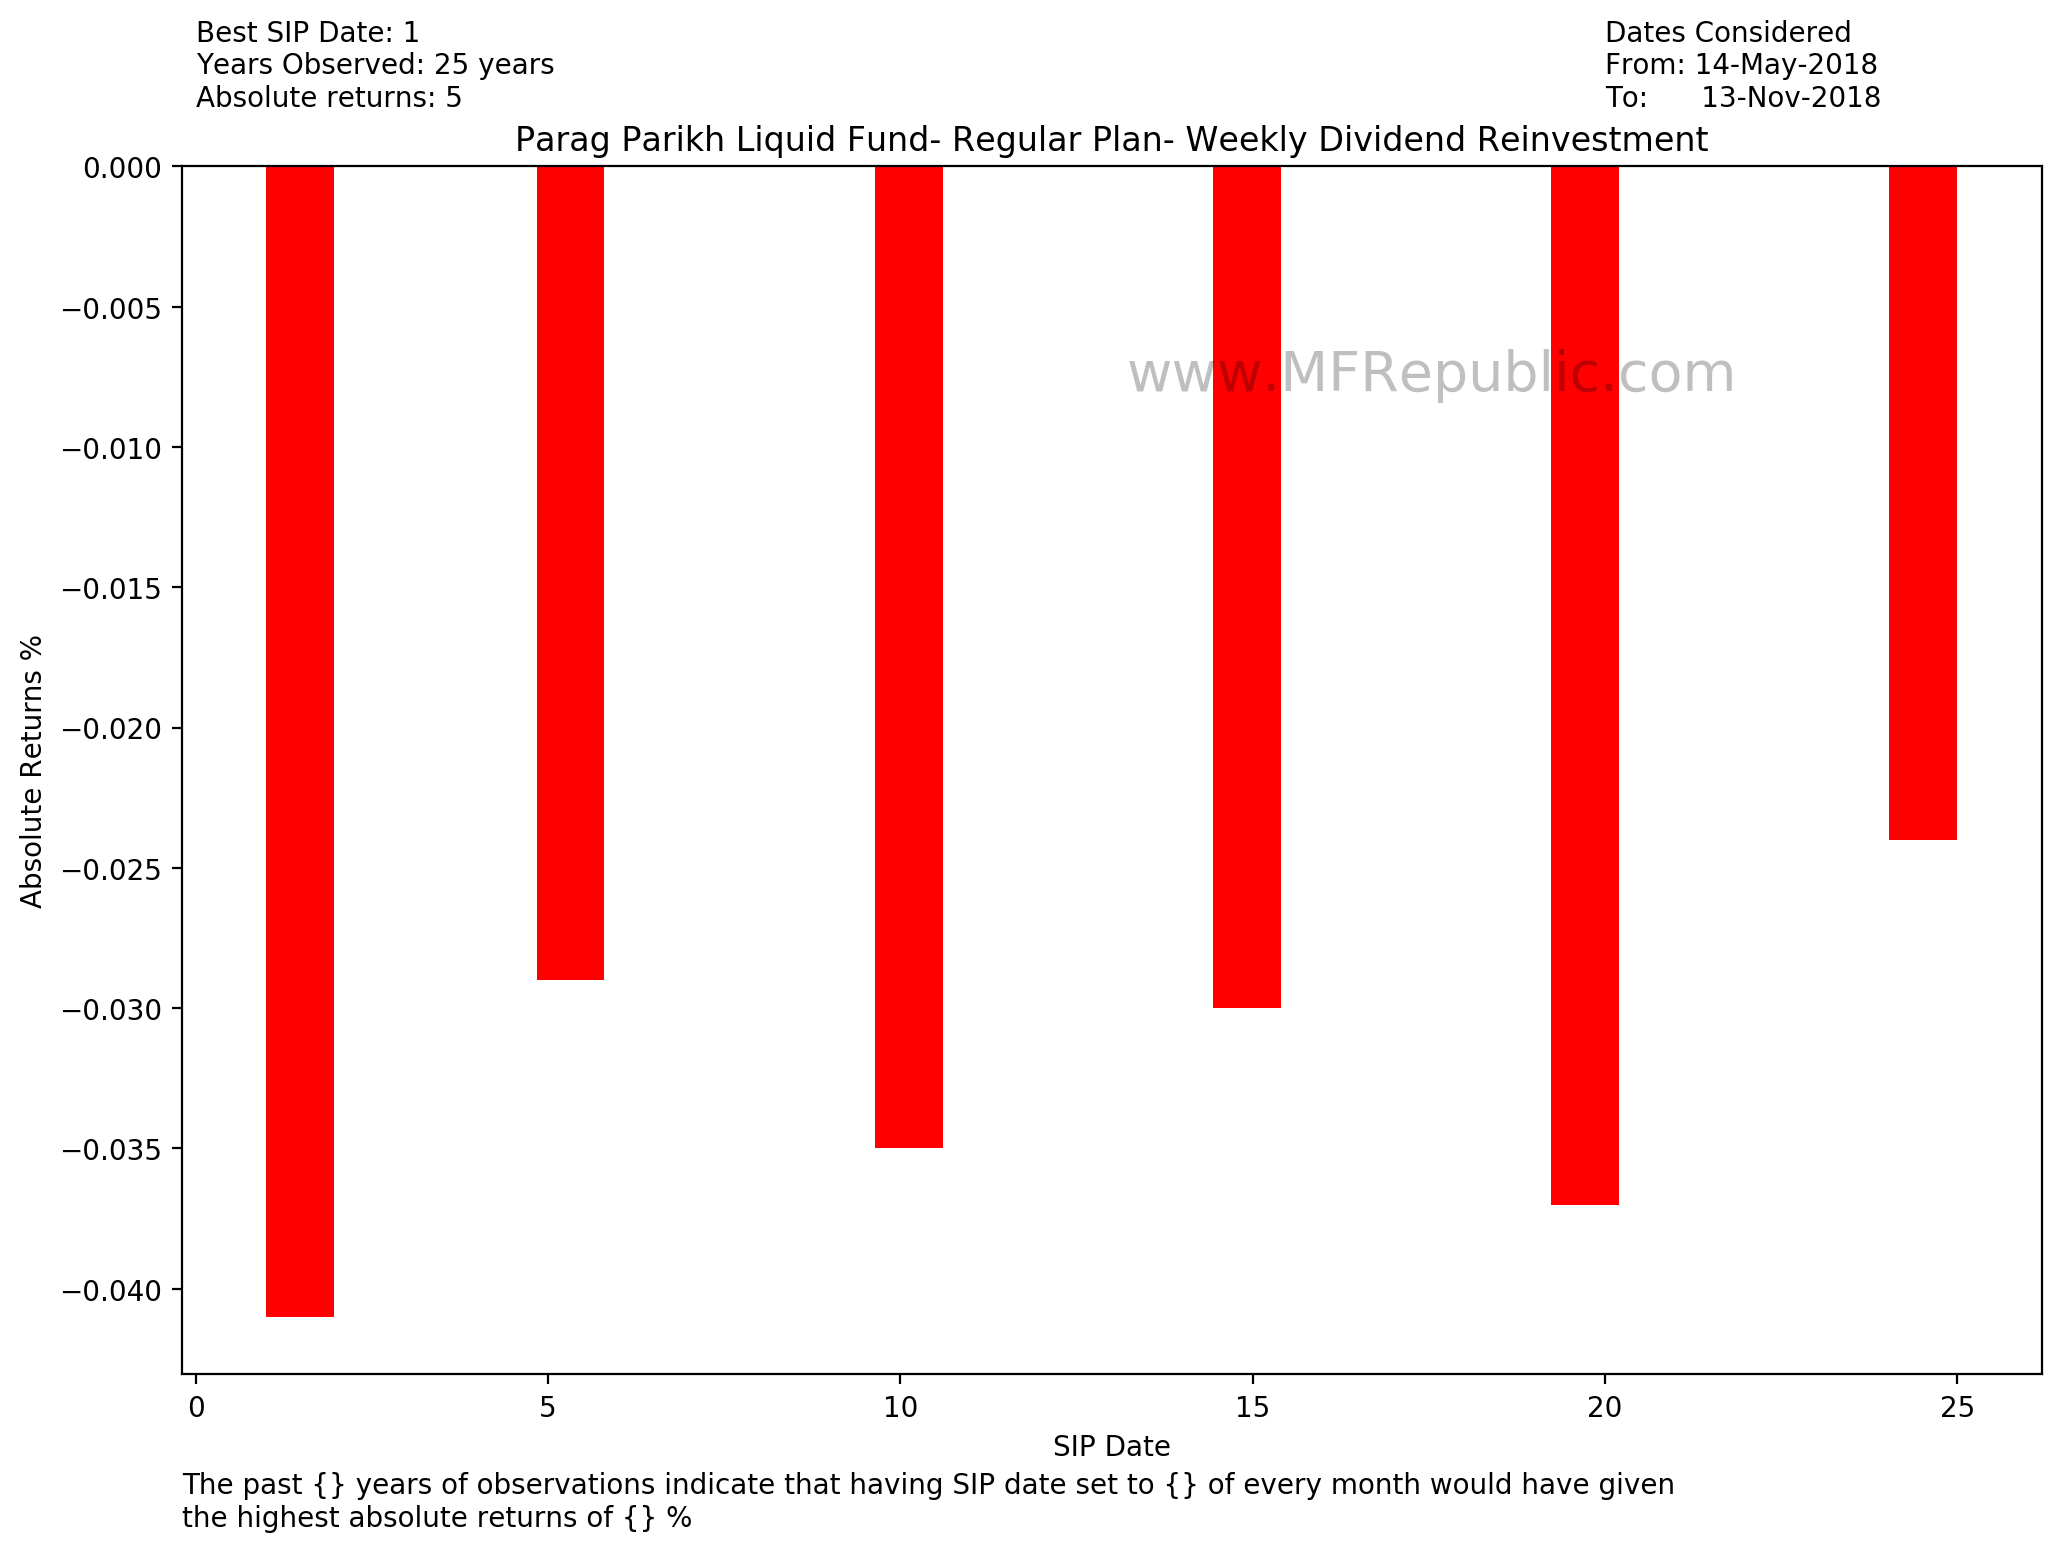

In [13]:
plt.figure(num=None, figsize=(12, 8), dpi=200)
plt.hist(d['SIP Date'], weights=d['AvgAbsReturns%'], facecolor= 'r' if d['AvgAbsReturns%'].mean() < 0 else 'g', bins = 25)
plt.xlabel('SIP Date')
plt.ylabel('Absolute Returns %')
plt.title(schemeName)
plt.text(0, 0.001, 'Best SIP Date: {} \nYears Observed: {} years \nAbsolute returns: {}\n'.format(1,yr,5))
plt.text(20, 0.001, 'Dates Considered\nFrom: {} \nTo:      {}\n'.format(fromDate,toDate))
#plt.text(0, .009, schemeName)
plt.annotate('The past {} years of observations indicate that having SIP date set to {} of every month would have given \nthe highest absolute returns of {} %', (0,0), (0, -35), xycoords='axes fraction', textcoords='offset points', va='top')
plt.savefig('output\plots\{}-{}.png'.format(schemeName,yr), dpi=200)
'''plt.text(0.95, 0.05, 'Property of MPL',
         fontsize=50, color='gray',
         ha='right', va='bottom', alpha=0.5)
'''
plt.annotate('www.MFRepublic.com', (0,0), (450, 350), 
             xycoords='axes fraction',fontsize=20,
             textcoords='offset points', ha='center', va='bottom', alpha = 0.25)
